# Bagging and Random Forest Classifier on MNIST Dataset

## Imports

In [ ]:
import matplotlib.pyplot as plt

from keras.datasets import mnist

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline

from sklearn.model_selection import ShuffleSplit

## Loading MNIST Dataset

We began by loading MNIST dataset using `load_data` function in `mnist` class

We obtain:
* Training feature matrix and labels
* Test feature matrix and labels

In [ ]:
#load dataset
(X_train, y_train),(X_test, y_test) = mnist.load_data()

Text(0.5, 1.0, '5')

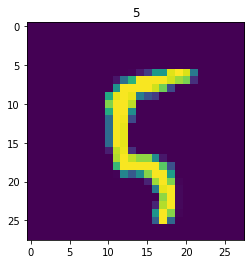

In [ ]:
plt.imshow(X_train[100])
plt.title(y_train[100])

As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28X28. There are 10 different labels - one for each digit -0 to 9.

In [ ]:
print('Shape of training data',X_train.shape)
print('Shape of training labels',y_train.shape)
print('Shape of testing data',X_test.shape)
print('Shape of testing labels',y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28X28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e. 255. In that sense we have each feature value in the range 0 to 1.

In [ ]:
#Flatten each input image into a vector of length 784

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

#normalizing

X_train = X_train/255
X_test  = X_test/255



In [ ]:
print('shape of training data after flattening',X_train.shape)
print('shape of test data after flattening',X_test.shape)
print('shape of training labels after flattening',y_train.shape)
print('shape of test labels after flattening',y_test.shape)

shape of training data after flattening (60000, 784)
shape of test data after flattening (10000, 784)
shape of training labels after flattening (60000,)
shape of test labels after flattening (10000,)


We began by loading MNIST dataset using `load_data` function in `mnist` class

We obtain:
* Training feature matrix and labels
* Test feature matrix and labels

In [ ]:
#load dataset
(X_train, y_train),(X_test, y_test) = mnist.load_data()

Text(0.5, 1.0, '5')

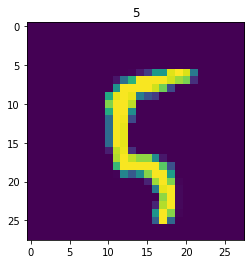

In [ ]:
plt.imshow(X_train[100])
plt.title(y_train[100])

As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28X28. There are 10 different labels - one for each digit -0 to 9.

In [ ]:
print('Shape of training data',X_train.shape)
print('Shape of training labels',y_train.shape)
print('Shape of testing data',X_test.shape)
print('Shape of testing labels',y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28X28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e. 255. In that sense we have each feature value in the range 0 to 1.

In [ ]:
#Flatten each input image into a vector of length 784

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

#normalizing

X_train = X_train/255
X_test  = X_test/255



In [ ]:
print('shape of training data after flattening',X_train.shape)
print('shape of test data after flattening',X_test.shape)
print('shape of training labels after flattening',y_train.shape)
print('shape of test labels after flattening',y_test.shape)

shape of training data after flattening (60000, 784)
shape of test data after flattening (10000, 784)
shape of training labels after flattening (60000,)
shape of test labels after flattening (10000,)


## Defining Functions to compare estimators

In [ ]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

We define two funcitons:

  1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem. 
  * It takes `estimator`, feature matrix, labels, cross validation strategy and name of the classifier as input.
  * It first fits the estimator with feature matrix and labels.
  * It obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it.
  

In [ ]:
def train_classifiers(estimator, X_train, y_train, cv, name):
  estimator.fit(X_train, y_train)

  cv_train_score = cross_val_score(estimator, X_train, y_train, cv = cv, scoring = 'f1_macro')

  print(f"On an average, {name} model has f1 score of "f"{cv_train_score.mean():.3f}+/-{cv_train_score.std():.3f} on the training set")


2. The `eval` function takes estimator, test feature matrix and labels as input and produce classification report and confusion matrix.
  * It first predicts labels for the test set.
  * Then it uses these predicted reports for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the 10 classes.
  * It also obtains a confusion matrix by comparing these predictions iwth the actual labels and displays it with `ConfusionMatrixDisplay` utility.

In [ ]:
def eval(estimator, X_test, y_test):
  y_pred = estimator.predict(X_test)

  print('classification_report')
  print(classification_report(y_test,y_pred))

  print("Confusion Matrix")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

  plt.title('Confusion Matrix')
  plt.show()

Let's train three classifiers with default parameters.
 * Decision tree 
 * Bagging classifier-which uses decision tree as a default classifier and trains multiple decision tree classifiers on different bags obtained through boostrap sampling of training set.
 * Random forest classifier-which is also a bagging technique, which trains different decision tree classifiers by randomly selecting attributes for splitting on bags of boostrap sample of training set.
 

 ## **Decision trees for MNIST multiclass classification**
 We instantiate a decision tree classifier with default parameters and train it. The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [ ]:
decision_tree_pipeline = Pipeline([('classifier', DecisionTreeClassifier())])
train_classifiers(decision_tree_pipeline,X_train, y_train.ravel(), cv, 'Decision Tree')

On an average, Decision Tree model has f1 score of 0.867+/-0.004 on the training set


classification_report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.95      0.96      0.95      1135
           2       0.87      0.86      0.86      1032
           3       0.82      0.85      0.84      1010
           4       0.87      0.88      0.88       982
           5       0.84      0.85      0.84       892
           6       0.90      0.89      0.90       958
           7       0.92      0.90      0.91      1028
           8       0.82      0.81      0.82       974
           9       0.86      0.85      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix


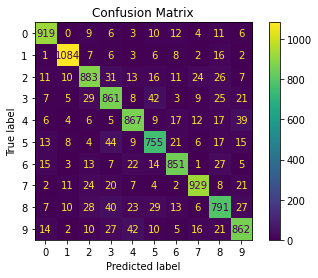

In [ ]:
eval(decision_tree_pipeline, X_test, y_test.ravel())

## **MNIST** classification with Bagging

Let's instantiate a bagging classifier object with default parameters and train it.

Observe the mean `f1_score` and its standard deviation obtained by the classifier based 10-fold cross validation of the training set.

In [ ]:
Bagging = BaggingClassifier()
train_classifiers(Bagging,X_train, y_train.ravel(), cv, 'BaggingClassifier')


On an average, BaggingClassifier model has f1 score of 0.938+/-0.004 on the training set


Let's evaluate the trained classifier on the test set.

classification_report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.94      0.93      1032
           3       0.93      0.94      0.93      1010
           4       0.94      0.95      0.94       982
           5       0.93      0.92      0.93       892
           6       0.95      0.95      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.90      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Confusion Matrix


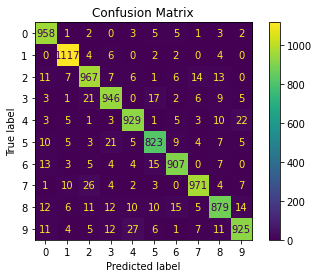

In [ ]:
eval(Bagging, X_test, y_test.ravel())

## **Random forest for MNIST multiclass classification** 
Let's instantiate a random forest classifier object with default parameters and train it.
Observe the mean `f1_score` and its standard deviation obtained by the classifier based 10-fold cross validation of the training set.

In [ ]:
random_forest = RandomForestClassifier()
train_classifiers(random_forest, X_train, y_train.ravel(), cv, 'Random Forest')

On an average, Random Forest model has f1 score of 0.967+/-0.001 on the training set


et's evaluate a random forest classifier on the test set and obtain classification report containing precision, recall, f1-score and accuracy for each class. It also calculates confusion matrix and displays it with ConfusionMatrixDisplay utility.

classification_report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion Matrix


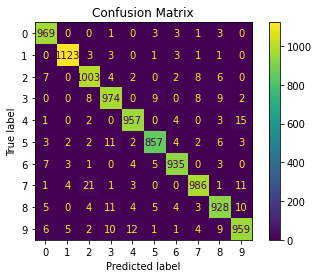

In [ ]:
eval(random_forest, X_test, y_test.ravel())

## Summary 
 * We trained three multi-class classifiers for handwritten digit recognition.
 * The decision tree classifier is a baseline classifier, which obtained accuracy of 88% on the test set.
 * Using bagging and training the same decision tree classifier gave us an increase of 6 percentage point in the accuracy, which translates to 94% accuracy on the test set.
 * Finally random forest pushed that further to 97%.
 * We can see that how ensemble techniques give better results on the classification task compared to a single classifier.
 * With this demonstration, you have added three more powerful tools in your ML toolkit.

# Bagging and Random Forest Regressor on California Housing Dataset

In this colab, we will apply ensemble techniques regression problem in california housing dataset.

We have already applied different regressors on california housing dataset. In this colab, we will make use of 
  * Decision tree regressor 
  * Bagging regressor 
  * Random Forest regressor 
we will observe performance improvement when we use random forest over decision trees and bagging, which also uses decision tree regressors.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline


In [ ]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as text examples.

In [ ]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

In [ ]:
features, labels = fetch_california_housing(as_frame = True, return_X_y = True)

labels *=  100

com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state = 42)

train_features,dev_features, train_labels ,dev_labels = train_test_split(com_train_features, com_train_labels, random_state = 42)

In [ ]:
train_features.shape, com_train_features.shape

((11610, 8), (15480, 8))

## Training Different Regressors

In [ ]:
def train_regressor(estimator, X_train, y_train, cv, name):

  cv_regressor = cross_validate(estimator,
                                X_train,
                                y_train,
                                cv = cv,
                                scoring = 'neg_mean_absolute_error',
                                return_train_score = True,
                                return_estimator = True)
  
  cv_train_error = -1 * cv_regressor['train_score']
  cv_test_error = -1 * cv_regressor['test_score']

  print(f'On an average {name} makes a training error of {cv_train_error.mean():.3f}k +/- {cv_train_error.std():.3f}')
  print(f'On an average {name} makes a test error of {cv_test_error.mean():.3f}k +/- {cv_test_error.std():.3f}')
   

In [ ]:
train_regressor(DecisionTreeRegressor(), 
                com_train_features, com_train_labels, cv = cv ,name = 'Decision Tree Regressor')

On an average Decision Tree Regressor makes a training error of 0.000k +/- 0.000
On an average Decision Tree Regressor makes a test error of 47.259k +/- 1.142


In [ ]:
train_regressor(BaggingRegressor(),
                com_train_features, com_train_labels, cv = cv, name = 'Bagging Regressor')

On an average Bagging Regressor makes a training error of 14.377k +/- 0.196
On an average Bagging Regressor makes a test error of 35.217k +/- 0.608


In [ ]:
train_regressor(RandomForestRegressor(),
                com_train_features, com_train_labels, cv = cv, name = 'Random Forest')

On an average Random Forest makes a training error of 12.642k +/- 0.071
On an average Random Forest makes a test error of 33.198k +/- 0.718


## Parameter Search for Random Forest Regressor


In [ ]:
param_distributions = {
    'n_estimators': [1,2,5,10,20,50,100,200,500],
    'max_leaf_nodes': [2,5,10,20,50,100]
}

search_cv = RandomizedSearchCV(RandomForestRegressor(n_jobs = 2),
                               param_distributions  = param_distributions,
                               scoring = 'neg_mean_absolute_error',
                               n_iter = 10,
                               n_jobs = 2,
                               random_state = 0)



search_cv.fit(com_train_features, com_train_labels) 



In [ ]:
columns = [f'param_{name}' for name in param_distributions.keys()]
columns += ['mean_test_error', 'std_test_error']

cv_results = pd.DataFrame(search_cv.cv_results_)

cv_results['mean_test_error'] = -1 * cv_results['mean_test_score']
cv_results['std_test_error'] = -1 * cv_results['std_test_score']

cv_results[columns]

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
0,500,100,40.592138,-0.785397
1,100,20,49.602715,-1.111436
2,10,100,41.241278,-1.134843
3,500,10,55.002778,-1.043582
4,5,5,61.415114,-1.079793
5,5,2,73.649349,-1.366727
6,50,20,49.722633,-0.849181
7,100,50,43.883959,-0.915991
8,1,100,46.210125,-1.513173
9,10,20,49.599278,-1.234409


# Adaboost and Gradient Classifier on MNIST

## Import

In [3]:
import matplotlib.pyplot as plt 
from keras.datasets import mnist

from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score 

from sklearn.model_selection import ShuffleSplit 


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import classification_report 

from sklearn.pipeline import Pipeline 



## Loading MNIST Dataset

We began by loading MNIST dataset using `load_data` function in `mnist` class

We obtain:
* Training feature matrix and labels
* Test feature matrix and labels

In [4]:
#load dataset
(X_train, y_train),(X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Text(0.5, 1.0, '5')

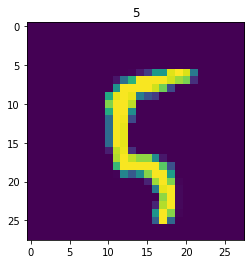

In [5]:
plt.imshow(X_train[100])
plt.title(y_train[100])

As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28X28. There are 10 different labels - one for each digit -0 to 9.

In [6]:
print('Shape of training data',X_train.shape)
print('Shape of training labels',y_train.shape)
print('Shape of testing data',X_test.shape)
print('Shape of testing labels',y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28X28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e. 255. In that sense we have each feature value in the range 0 to 1.

In [7]:
#Flatten each input image into a vector of length 784

X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

#normalizing

X_train = X_train/255
X_test  = X_test/255



In [8]:
print('shape of training data after flattening',X_train.shape)
print('shape of test data after flattening',X_test.shape)
print('shape of training labels after flattening',y_train.shape)
print('shape of test labels after flattening',y_test.shape)

shape of training data after flattening (60000, 784)
shape of test data after flattening (10000, 784)
shape of training labels after flattening (60000,)
shape of test labels after flattening (10000,)


## Defining Functions to compare estimators

In [9]:
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)

We define two funcitons:

  1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem. 
  * It takes `estimator`, feature matrix, labels, cross validation strategy and name of the classifier as input.
  * It first fits the estimator with feature matrix and labels.
  * It obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it.
  

In [10]:
def train_classifiers(estimator, X_train, y_train, cv, name):
  estimator.fit(X_train, y_train)

  cv_train_score = cross_val_score(estimator, X_train, y_train, cv = cv, scoring = 'f1_macro')

  print(f"On an average, {name} model has f1 score of "f"{cv_train_score.mean():.3f}+/-{cv_train_score.std():.3f} on the training set")


2. The `eval` function takes estimator, test feature matrix and labels as input and produce classification report and confusion matrix.
  * It first predicts labels for the test set.
  * Then it uses these predicted reports for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the 10 classes.
  * It also obtains a confusion matrix by comparing these predictions iwth the actual labels and displays it with `ConfusionMatrixDisplay` utility.

In [11]:
def eval(estimator, X_test, y_test):
  y_pred = estimator.predict(X_test)

  print('classification_report')
  print(classification_report(y_test,y_pred))

  print("Confusion Matrix")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

  plt.title('Confusion Matrix')
  plt.show()

Let's train two classifiers with default parameters.
* `AdaBoostClassifier` that uses decision stumps as weak learners.
* `GradientBoostingClassifier` that uses decision trees as weak learners.


## **AdaBoost for MNIST multiclass classification**
We instantiate a decision tree classifier with default parameters and train it. The train_classifier function print means of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [13]:
abc_pipeline  = Pipeline([('classifier', AdaBoostClassifier())])

train_classifiers(abc_pipeline, X_train, y_train.ravel(), cv, 'AdaBoostClassifier')

On an average, AdaBoostClassifier model has f1 score of 0.712+/-0.016 on the training set


classification_report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       980
           1       0.85      0.94      0.90      1135
           2       0.79      0.58      0.67      1032
           3       0.68      0.67      0.68      1010
           4       0.72      0.72      0.72       982
           5       0.69      0.59      0.64       892
           6       0.72      0.86      0.78       958
           7       0.68      0.78      0.73      1028
           8       0.66      0.68      0.67       974
           9       0.62      0.55      0.58      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.73     10000

Confusion Matrix


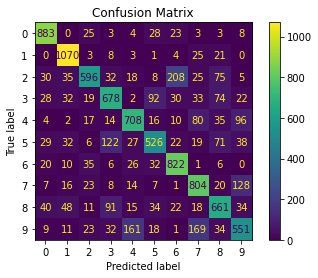

In [14]:
eval(abc_pipeline,X_test,y_test.ravel())